In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
order_products_train = pd.read_csv("data/order_products__train.csv")
order_products_prior = pd.read_csv("data/order_products__prior.csv")
products = pd.read_csv("data/products.csv")

# 1. "order\_products\_*.csv" Data Analysis

In [3]:
print("The order_products_prior size is : ", order_products_prior.shape)
order_products_prior.head(5)

The order_products_prior size is :  (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
print("The order_products_train size is : ", order_products_train.shape)
order_products_train.head(5)

The order_products_train size is :  (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Make order_products_all (prior+train)

In [5]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", len(order_products_all))
order_products_all.head(5)

The order_products_all size is :  33819106


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Check Unique orders and ordered products

In [6]:
# Check the number of unique orders and unique products
orders_Unique = len(order_products_all.order_id.unique())
products_Unique = len(order_products_all.product_id.unique())
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


## 1-1) Missing Data

In [7]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


    ➢ order_products_* 에는 Missing Data가 없음.

## 1-2) 한 번에 몇 개의 products를 주문하는가?

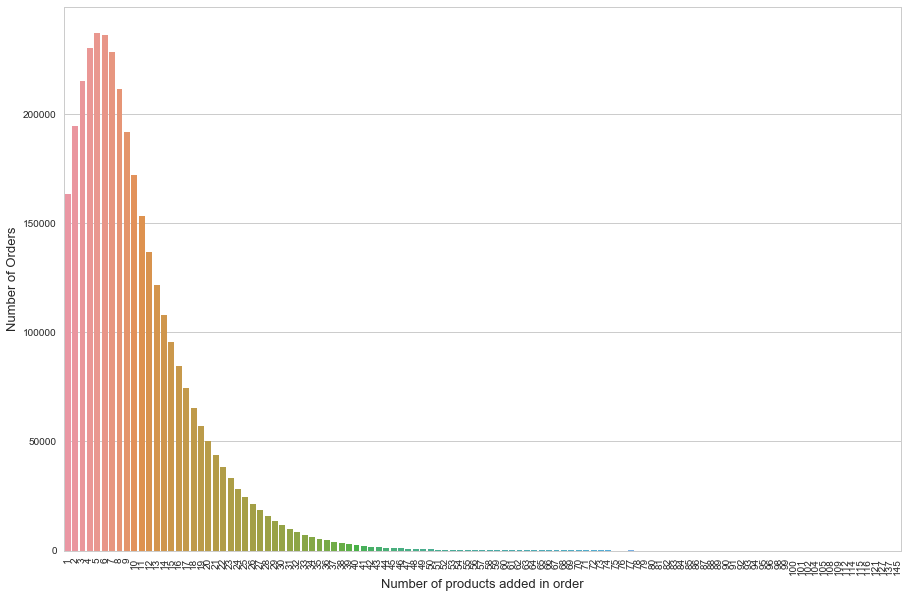

In [8]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

    ➢ 대부분 약 20개 이내의 products를 한 번에 주문함.

## 1-3) 가장 많이 팔린 제품(products)은 무엇인가?

In [9]:
grouped = pd.value_counts(order_products_all.product_id).reset_index()
grouped.columns = ['product_id', 'Total_Orders']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped.head(10)

,product_id,Total_Orders,product_name
0,24852,491291,Banana
1,13176,394930,Bag of Organic Bananas
2,21137,275577,Organic Strawberries
3,21903,251705,Organic Baby Spinach
4,47209,220877,Organic Hass Avocado
5,47766,184224,Organic Avocado
6,47626,160792,Large Lemon
7,16797,149445,Strawberries
8,26209,146660,Limes
9,27845,142813,Organic Whole Milk


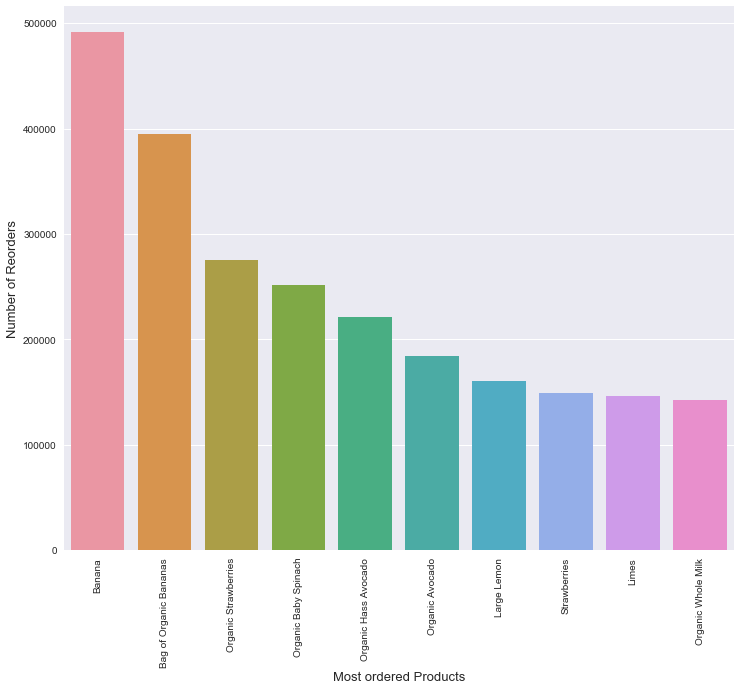

In [10]:
grouped = grouped[:10]
grouped = grouped.groupby(['product_name']).sum()['Total_Orders'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

## 1-4) 가장 많이 재구매(reordered)를 한 제품은 무엇인가?

In [11]:
grouped = order_products_all.groupby('product_id')['reordered'].sum().reset_index()
grouped.columns = ['product_id', 'frequency']
grouped.sort_values(by='frequency', ascending=False, inplace=True)
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped.head(10)

,product_id,frequency,product_name
0,24852,415166,Banana
1,13176,329275,Bag of Organic Bananas
2,21137,214448,Organic Strawberries
3,21903,194939,Organic Baby Spinach
4,47209,176173,Organic Hass Avocado
5,47766,140270,Organic Avocado
6,27845,118684,Organic Whole Milk
7,47626,112178,Large Lemon
8,27966,109688,Organic Raspberries
9,16797,104588,Strawberries


## 1-5) 재구매할 확률*(reorders/total_orders)*이 가장 높은 제품은 무엇인가?

In [12]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'order_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['order_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.order_total > 100].sort_values(['reorder_probability'], ascending=False)
grouped.head(10)

/Users/Joohong/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,product_id,order_total,reorder_sum,reorder_probability,product_name
27737,27740,102,94,0.921569,Chocolate Love Bar
35601,35604,104,93,0.894231,Maca Buttercups
38248,38251,111,99,0.891892,Benchbreak Chardonnay
10233,10236,131,114,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,114,99,0.868421,Thousand Island Salad Snax
35493,35496,457,394,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2995,2580,0.861436,Half And Half Ultra Pasteurized
45501,45504,9410,8091,0.859830,Whole Organic Omega 3 Milk
17466,17469,484,416,0.859504,Lo-Carb Energy Drink
43391,43394,8742,7511,0.859186,Organic Lactose Free Whole Milk


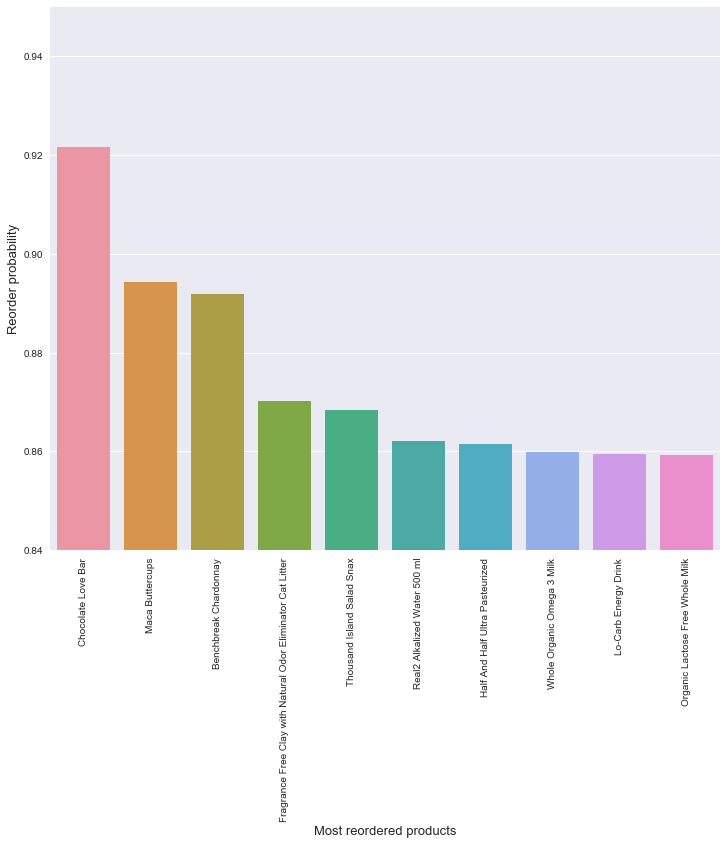

In [13]:
grouped = grouped[:10]
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylim([0.84,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=13)
plt.show()

## 1-6) 첫구매 vs 재구매 비율

In [14]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

/Users/Joohong/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062
